# Convolutional Neural Networks for Handwritten Digit Recognition

Object recognition is one of the most exciting tasks in the field of Computer Vision. The goal is to detect and identify objects in an image. The most popular dataset in object recognition involves recognizing handwritten digits. In this part of the lab, we will develop a convolutional neural network for classifying handwritten digits using the [Keras](https://keras.io/) library. We will evaluate the neural network on the well-known [MNIST dataset](http://yann.lecun.com/exdb/mnist/). The dataset was created by Yann LeCun, Corinna Cortes and Christopher Burges for evaluating machine learning models. Each instance corresponds to the image of a digit taken from a scanned document. Each image is a 28 by 28 pixel square (784 pixels total), and the digits are normalized in size and centred. There are 10 digits in total (0 to 9). Hence, there are 10 classes in total. The dataset is spit into a training set consisting of 60,000 images and a test set of 10,000 images.

Keras provides a function for directly loading the MNIST dataset. The dataset is downloaded automatically the first time this function is called and is stored in the disk. Run the following code to load the MNIST dataset. Then, use the ``show`` function (already implemented) to visualize a digit of the training set.

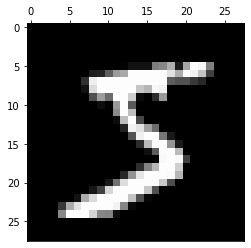

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow.keras.datasets import mnist

def show(image):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap='gray')
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


show(X_train[0,:,:])

To reduce training time, we will carry out experiments only on a subset of the dataset. Specifically, the first 10,000 instances of the training set and the first 1,000 instances of the test set will serve as our new training and test sets, respectively.

In [2]:
X_train = X_train[:10000,:,:]
y_train = y_train[:10000]
X_test = X_test[:1000,:,:]
y_test = y_test[:1000]

After loading the MNIST dataset and reducing its size, it is necessary to reshape all the instances so that their shape is the one a CNN would expect. In Keras, the layers used for two-dimensional convolutions expect the depth of the input image along with its dimensions. In the case of full-color images, the depth is equal to 3 and each dimension corresponds to its red, green and blue components. The images contained in the MNIST dataset are greyscale, hence, the depth is equal to 1. Therefore, to be able to apply two-dimensional convolutions, it is necessary to transform the shape of each image from (width, height) to (width, height, depth). Make use of the [reshape](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.reshape.html) function of NumPy to add an extra dimension to the training and test matrices.

In [3]:
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 28, 28, 1))

print("Shape of training matrix:", X_train.shape)
print("Shape of test matrix:", X_test.shape)

Shape of training matrix: (10000, 28, 28, 1)
Shape of test matrix: (1000, 28, 28, 1)


The final preprocessing step is to convert the type of the images to float32, normalize their values to the range [0,1] and to encode the class labels using a one-hot scheme.

In [4]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Shape of training matrix:", X_train.shape)
print("Shape of test matrix:", X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Shape of training matrix: (10000, 28, 28, 1)
Shape of test matrix: (10000, 28, 28, 1)
10000 train samples
1000 test samples


Upon completing the preprocessing pipeline, we can now start developing the [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN) architecture. Keras provides rich functionality for building CNNs since it offers various methods for creating convolutional and pooling layers. We first initialize a Sequential model.

In [5]:
from tensorflow.keras.models import Sequential

model = Sequential()

We next add a two-dimensional convolution layer to our model. This layer will create a convolution kernel that is convolved with the layer input to produce a tensor of outputs. Use the [`Conv2D`](https://keras.io/layers/convolutional/#conv2d) method of Keras to generate a convolution layer with 32 filters of size (3,3) and a ReLU activation function.

In [6]:
from tensorflow.keras.layers import Conv2D

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)))

Add a second convolution layer to the model. Set the number of filters to 64 and their size to (2,2). As in the case of the first layer use a ReLU activation function.

In [7]:
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))

Then, define a pooling layer using the [`MaxPooling2D`](https://keras.io/layers/pooling/#maxpooling2d) method of Keras. Max pooling reduces the number of parameters in the model by sliding a 2x2 pooling filter on the output of the previous layer and taking the max of the 4 values in the 2x2 filter.

In [8]:
from tensorflow.keras.layers import MaxPooling2D

model.add(MaxPooling2D(pool_size=(2,2)))

The next layer is a regularization layer using dropout. Use the [`Dropout`](https://keras.io/layers/core/#dropout) method of Keras to randomly exclude 20% of the neurons in the layer. Dropout has been shown to reduce overfitting.

In [9]:
from tensorflow.keras.layers import Dropout

model.add(Dropout(rate=0.2))

We next transform the two-dimensional matrix that has emerged from the previous layers to a vector using the [`Flatten`](https://keras.io/layers/core/#flatten) function of Keras. This vector will serve as the input to a standard feedforward neural network. We also create a fully connected layer with 128 neurons and a ReLU activation function. Finally, we add an output layer consisting of 10 neurons for the 10 classes along with a softmax activation function to output probability-like predictions for each class.

In [10]:
from tensorflow.keras.layers import Dense, Flatten

model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

We next compile the model and by declaring the loss function and the optimizer.

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

We next print a summary representation of the model we generated. 

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 64)        8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

We can now train the neural network and use it to make predictions. Train the model for 10 epochs. Set the batch size to 64. Use the test data as the validation dataset. Once the training has finished, evaluate the model on the test set and print the classification accuracy. Note that training may take several minutes. You can reduce the training time by running the code on a GPU instead of CPU.

In [13]:
epochs = 10
batch_size = 64

model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.4265 - accuracy: 0.8744 - val_loss: 0.1964 - val_accuracy: 0.9390
Epoch 2/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.1166 - accuracy: 0.9653 - val_loss: 0.1128 - val_accuracy: 0.9590
Epoch 3/10
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.0696 - accuracy: 0.9793 - val_loss: 0.0907 - val_accuracy: 0.9680
Epoch 4/10
10000/10000 [==============================] - 11s 1ms/sample - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.0850 - val_accuracy: 0.9690
Epoch 5/10
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.0288 - accuracy: 0.9911 - val_loss: 0.1005 - val_accuracy: 0.9650
Epoch 6/10
10000/10000 [==============================] - 10s 1ms/sample - loss: 0.0171 - accuracy: 0.9948 - val_loss: 0.1056 - val_accuracy: 0.9660
Epoch 7/10
10000/10000 [==============================] -

The first layer of the neural network we implemented is a convolution layer. This convolution layer is applied directly to the greyscale images of the MNIST dataset, hence, an interesting task is to visualize what these filters have learned. Next, we apply the 32 filters to an image of the training set and we visualize the 26x26 output of each filter.

Shape of conv: (26, 26, 32)


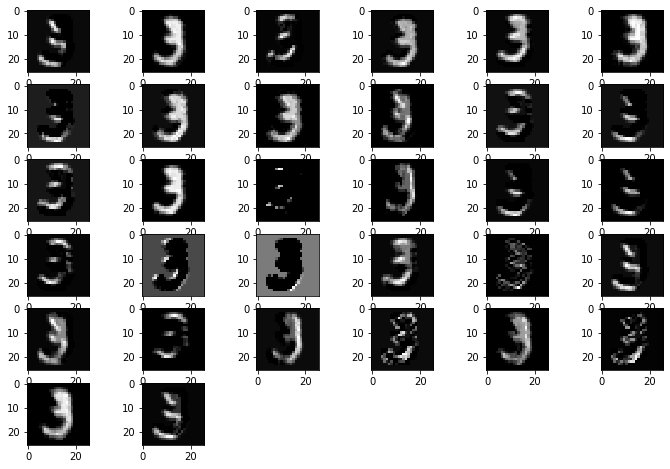

In [14]:
from tensorflow.keras import backend as K

def visualize(layer, img):
    convout1_f = K.function(model.inputs, [layer.output])

    convolutions = convout1_f(img)
    convolutions = np.squeeze(convolutions)

    print ('Shape of conv:', convolutions.shape)
    
    n = convolutions.shape[2]
    n = int(np.ceil(np.sqrt(n)))
    
    # Visualization of each filter of the layer
    fig = plt.figure(figsize=(12,8))
    for i in range(convolutions.shape[2]):
        ax = fig.add_subplot(n,n,i+1)
        ax.imshow(convolutions[:,:,i], cmap='gray')
        
# choose an image
image = X_train[10,:,:]

# Keras requires the image to be in 4D
image = np.expand_dims(image, axis=0)

# Specify the layer to want to visualize
convout = model.layers[0]
visualize(convout, image)

Generate translations of the images and investigate if the Convolutional Neural Network can achieve high performance on them.

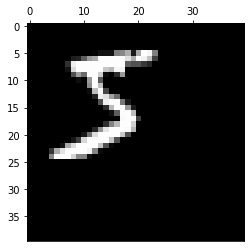

In [21]:
from random import random

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train[:10000,:,:]
y_train = y_train[:10000]
X_test = X_test[:1000,:,:]
y_test = y_test[:1000]

X_train_new = np.zeros((X_train.shape[0], 40, 40))
for i in range(X_train.shape[0]):
    r = random()
    if r <= 0.5:
        X_train_new[i,:28,:28] = X_train[i,:,:]
    else:
        X_train_new[i,12:,12:] = X_train[i,:,:]
        
X_test_new = np.zeros((X_test.shape[0], 40, 40))
for i in range(X_test.shape[0]):
    r = random()
    if r <= 0.5:
        X_test_new[i,12:,:28] = X_test[i,:,:]
    else:
        X_test_new[i,:28,12:] = X_test[i,:,:] 

        
show(X_train_new[0,:,:])

In [23]:
X_train_new = np.reshape(X_train_new, (X_train_new.shape[0], 40, 40, 1))
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], 40, 40, 1))

print("Shape of training matrix:", X_train.shape)
print("Shape of test matrix:", X_test.shape)

Shape of training matrix: (10000, 28, 28)
Shape of test matrix: (1000, 28, 28)


In [24]:
X_train_new = X_train_new.astype('float32')
X_test_new = X_test_new.astype('float32')
X_train_new /= 255
X_test_new /= 255
print("Shape of training matrix:", X_train_new.shape)
print("Shape of test matrix:", X_test_new.shape)
print(X_train_new.shape[0], 'train samples')
print(X_test_new.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Shape of training matrix: (10000, 40, 40, 1)
Shape of test matrix: (1000, 40, 40, 1)
10000 train samples
1000 test samples


In [32]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=(40,40,1)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.fit(X_train_new, y_train, epochs=10, batch_size=64, validation_data=(X_test_new, y_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 1.3038 - accuracy: 0.5513 - val_loss: 1.0305 - val_accuracy: 0.6670
Epoch 2/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.3612 - accuracy: 0.8889 - val_loss: 0.8381 - val_accuracy: 0.7330
Epoch 3/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.2539 - accuracy: 0.9250 - val_loss: 0.5406 - val_accuracy: 0.8350
Epoch 4/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.1866 - accuracy: 0.9438 - val_loss: 0.5619 - val_accuracy: 0.8290
Epoch 5/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.1649 - accuracy: 0.9520 - val_loss: 0.5475 - val_accuracy: 0.8270
Epoch 6/10
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.1488 - accuracy: 0.9539 - val_loss: 0.4035 - val_accuracy: 0.8750
Epoch 7/10
10000/10000 [==============================] -

The above model can in general remain invariant to image translations and achieve relatively high accuracy.